<a href="https://colab.research.google.com/github/achstu/biosignals/blob/main/ECG/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analiza EKG ##

#### Pobieranie sygnałów ####

In [ ]:
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.signal as ss

In [ ]:
url = "https://drive.google.com/drive/folders/1GZRTr_JhVx4XDjkLpNf7KMNdXANsJm8C?usp=sharing"
gdown.download_folder(url)

In [ ]:
!ls ekg_recordings/ | awk -F. '{print $1}' | uniq

film_nosleep
film_relaks
film_scary
film_trump
schody
spocz_brudne
spocz_czyste


In [ ]:
Fs = 2048
recordings = [
  "film_nosleep",
  "film_relaks",
  "film_scary",
  # "film_trump",
  "schody",
  "spocz_brudne",
  "spocz_czyste",
]

In [ ]:
def timespan(sig):
  return np.arange(0, len(sig) / Fs, 1 / Fs)

#### Montarze ####

In [ ]:
def einthoven(sig):
  dtype = [('I', '<f'), ('II', '<f'), ('III', '<f')]
  result = np.recarray(len(sig['L_hand']), dtype=dtype)

  result.I   = sig['L_hand'] - sig['R_hand']
  result.II  = sig['L_leg']  - sig['R_hand']
  result.III = sig['L_leg']  - sig['L_hand']

  return result

def goldberg(sig):
  dtype = [('I', '<f'), ('II', '<f'), ('III', '<f')]
  result = np.recarray(len(sig['L_hand']), dtype=dtype)

  result.I   = sig['R_hand'] - 0.5 * (sig['R_hand'] + sig['L_leg'])
  result.II  = sig['L_hand'] - 0.5 * (sig['R_hand'] + sig['L_leg'])
  result.III = sig['L_leg']  - 0.5 * (sig['L_hand'] + sig['L_leg'])

  return result

#### Filtracja ####

In [ ]:
def filter(sig):
  # górnoprzepustowy
  b, a = ss.butter(N=4, Wn=0.67, btype='highpass', analog=False, fs=Fs)
  sig = ss.filtfilt(b, a, sig)

  # dolnoprzepustowy
  b, a = ss.butter(N=2, Wn=150, btype='lowpass', analog=False, fs=Fs)
  sig = ss.filtfilt(b, a, sig)

  # notch
  b, a = ss.iirnotch(w0=50, Q=30, fs=Fs)
  ss.filtfilt(b, a, sig)

  return sig

#### Wczytywanie sygnału ####

In [ ]:
def signal(name):
  channels = ['L_hand', 'R_hand', 'L_leg']
  types = ['<f', '<f', '<f']
  dtype = list(zip(channels, types))

  sig = np.fromfile(f"ekg_recordings/{name}.obci.raw", dtype=dtype)

  # filtrownie i skalowanie
  for c in channels:
    sig[c] = 0.07150000333786011 * filter(sig[c])

  # montarz i wybór jednego kanału
  return filter(einthoven(sig)['II'])

In [ ]:
# rysuje pierwsze 5 sekund sygnału
def head(sig):
  sig = sig[:(5 * Fs)]
  plt.figure(figsize=(10, 4))
  plt.plot(timespan(sig), sig)
  plt.xlabel("Czas (s)")
  plt.ylabel("Napięcie (µV)")
  plt.show()

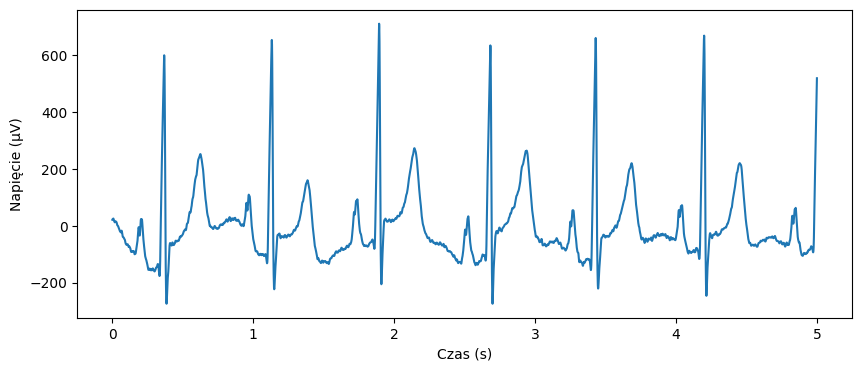

In [ ]:
sig = signal('spocz_czyste')
head(sig)

#### Identyfikacja załamków ####

In [ ]:
def sample_ekg_waves():
  sig = signal('schody')
  sample = sig[(10 * Fs) : (11 * Fs)]
  plt.figure(figsize=(8, 5))
  plt.plot(timespan(sample), sample)

  # tagi znalezione przy pomocy plotly.express scatter (interaktywnie)
  tags = [0.086, 0.180, 0.233, 0.322, 0.388, 0.553, 0.666]
  colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

  for (l, r), color in zip(zip(tags, tags[1:]), colors):
    plt.axvspan(l, r, alpha=0.2, fc=color)
  plt.show()

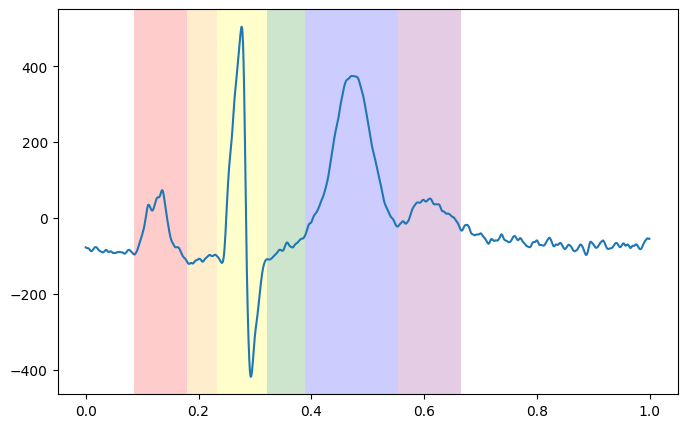

In [ ]:
# oznaczenia kolorystyczne tak samo jak na brain-wiki
sample_ekg_waves()

#### Detekcja pików R ####

In [ ]:
def find_R_peaks(sig):
  # zakładam max tętno 220
  # max tętno Hz: 220 / 60 = 3.67
  peaks, _ = ss.find_peaks(sig, distance=(Fs/3.67), height=400)
  return peaks

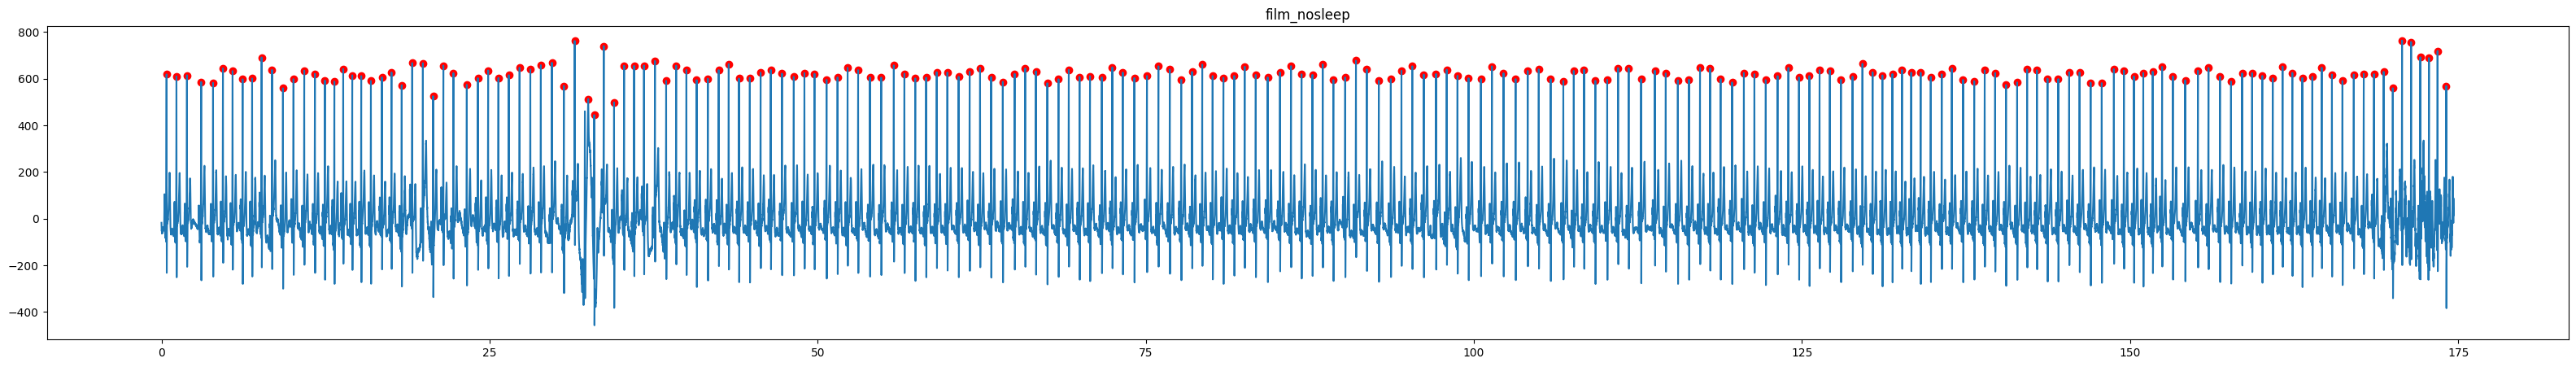

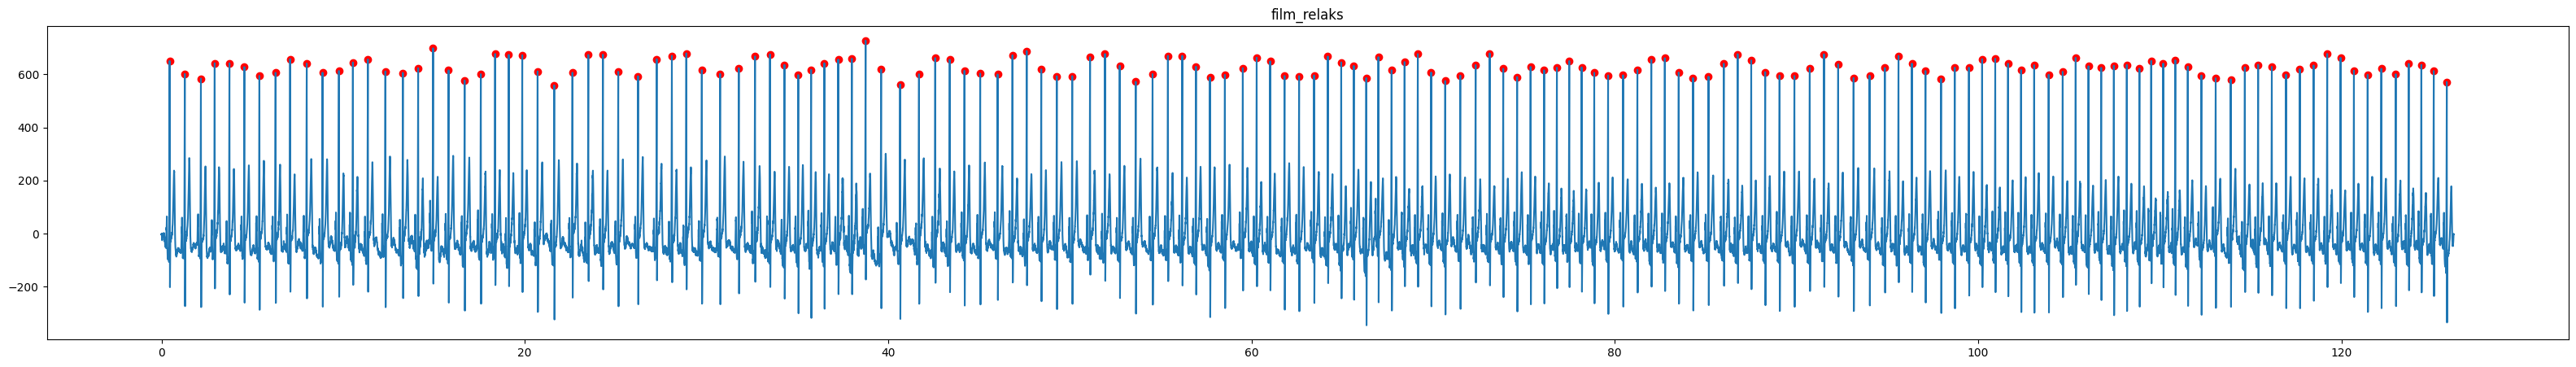

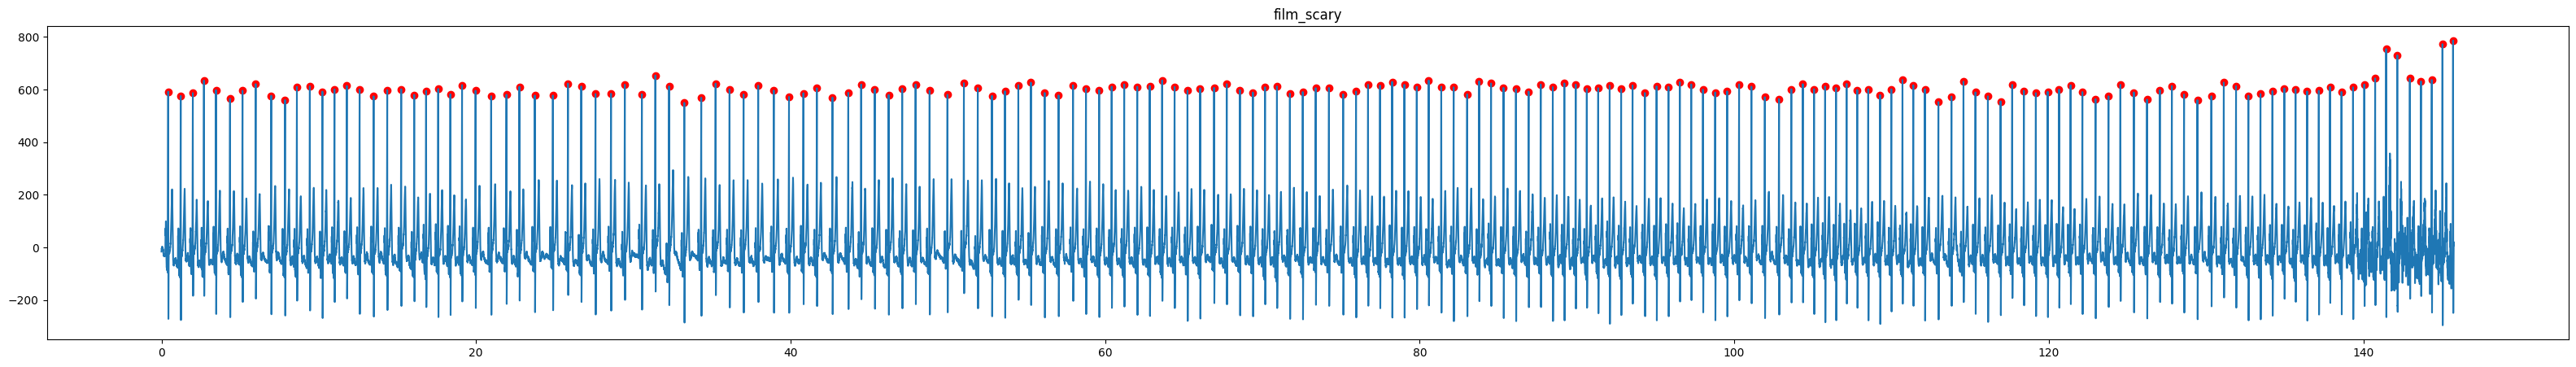

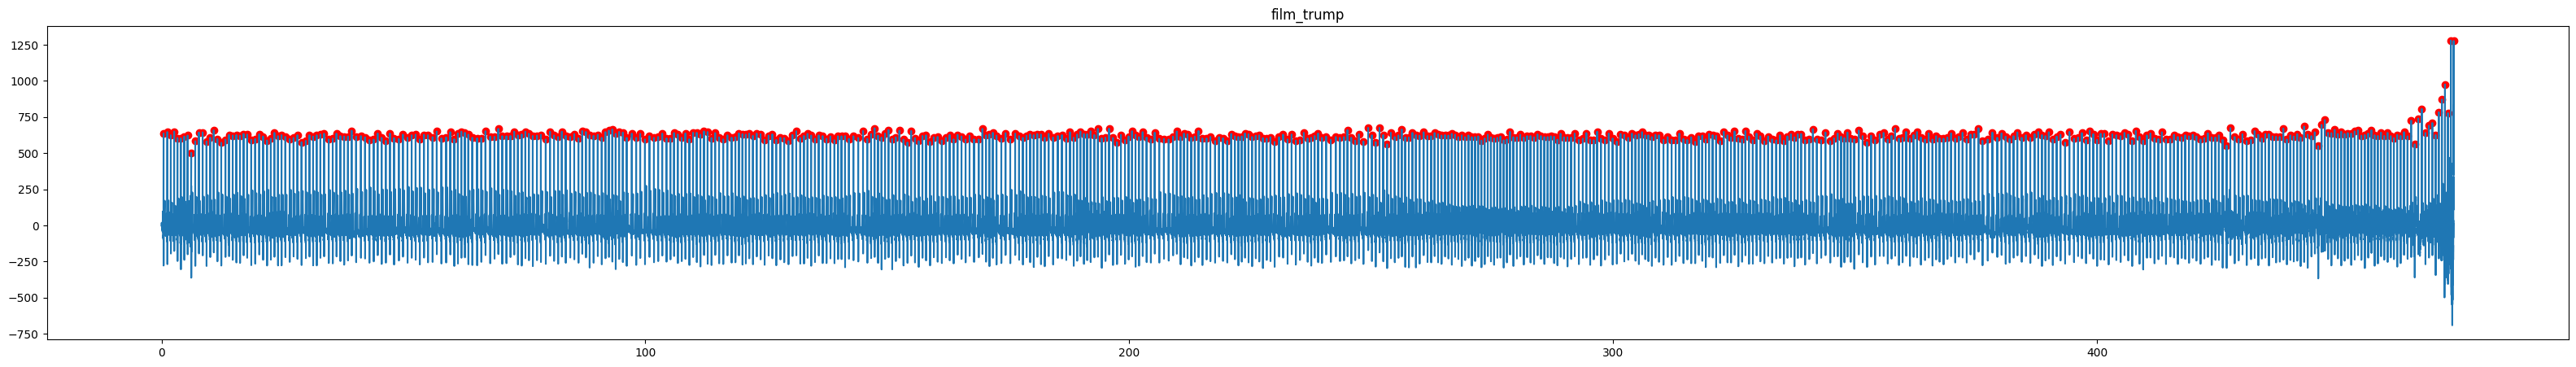

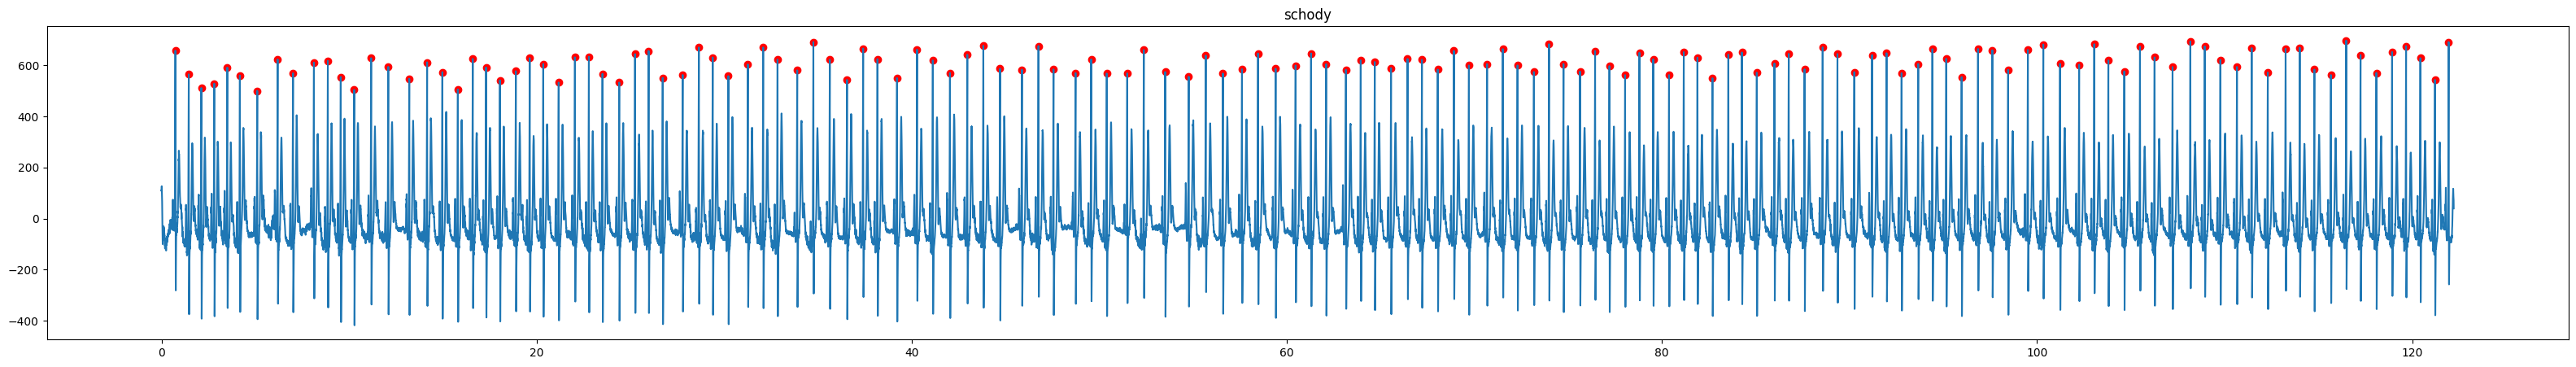

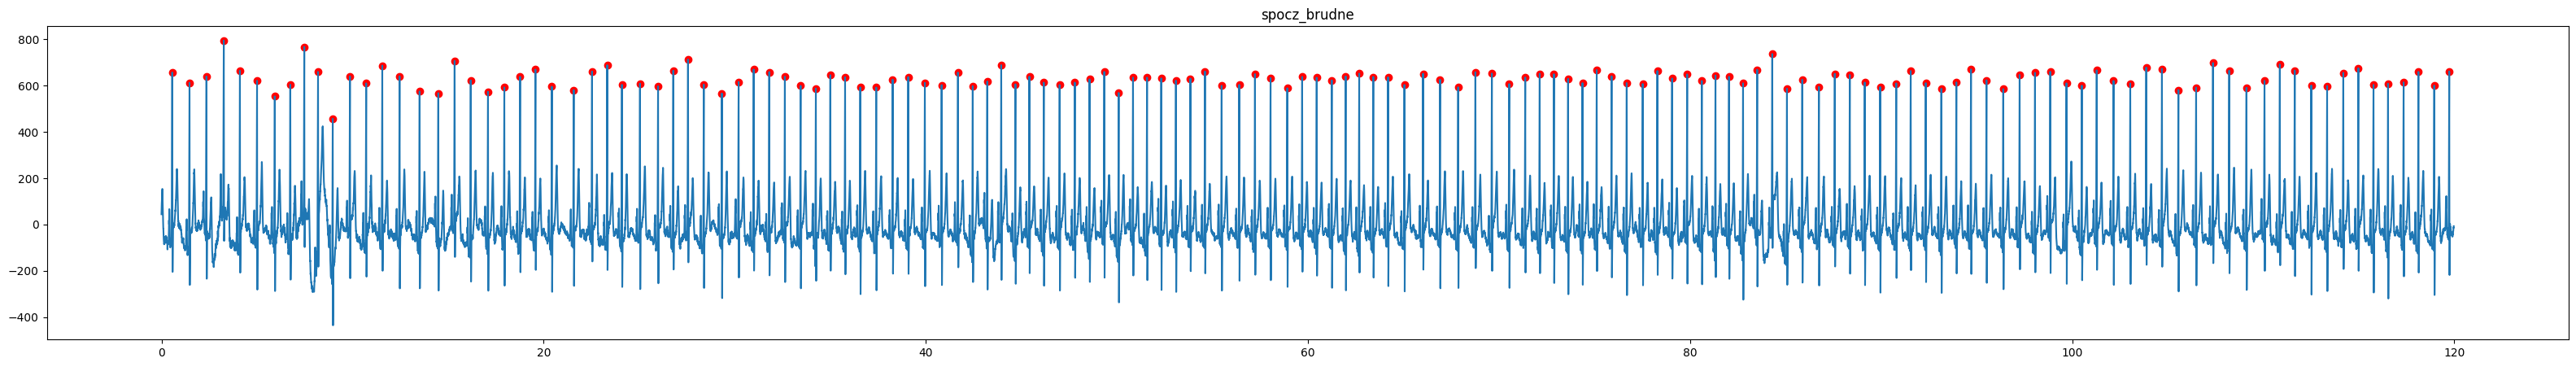

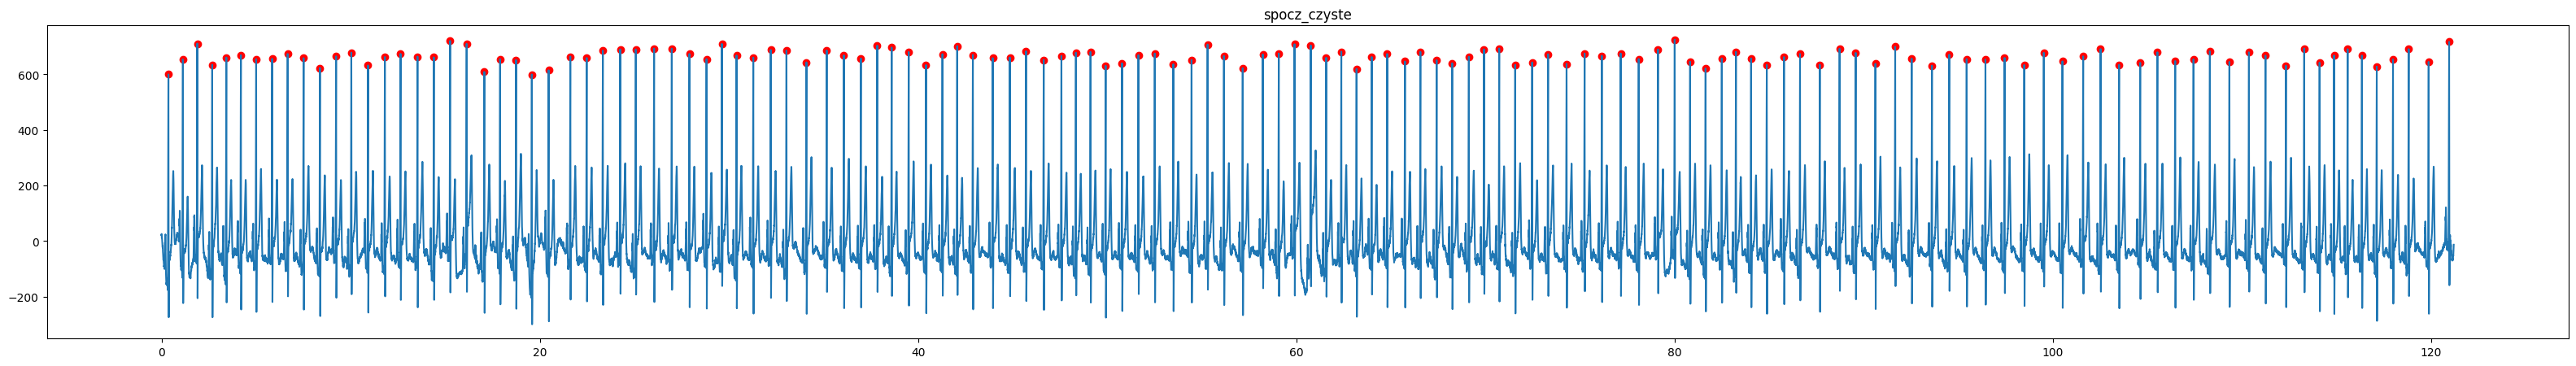

In [ ]:
for name in recordings:
  sig = signal(name)
  peaks = find_R_peaks(sig)

  plt.figure(figsize=(40, 5))
  plt.title(name)
  plt.plot(timespan(sig), sig)
  plt.scatter(peaks / Fs, sig[peaks], color='red')
  plt.show()

#### Tętno ####

In [ ]:
def hr(sig):
  peaks = find_R_peaks(sig)
  rr_x = 0.5 * (peaks[:-1] + peaks[1:]) / Fs
  rr = 60 / (np.diff(peaks) / Fs)

  interp = np.interp(timespan(sig), rr_x, rr)

  # Dodatkowo sensowane wydaje się zrobienie moving_average,
  # żeby tętno chwilowe nie skakało tak bardzo, tylko było
  # średnią z małego wycinka czasu
  def ma(x, window_size):
    weight = np.ones(window_size) / window_size
    return np.convolve(x, weight, mode='same')

  # Uwaga: wtedy jest problem na brzegach...
  # interp = ma(interp, 5)

  plt.plot(timespan(sig), interp)
  # plt.scatter(rr_x, rr, color='red')
  plt.show()

  print(f"Średnie tętno: {rr.mean()}")
  print(f"Odchylenie std.: {rr.std()}")

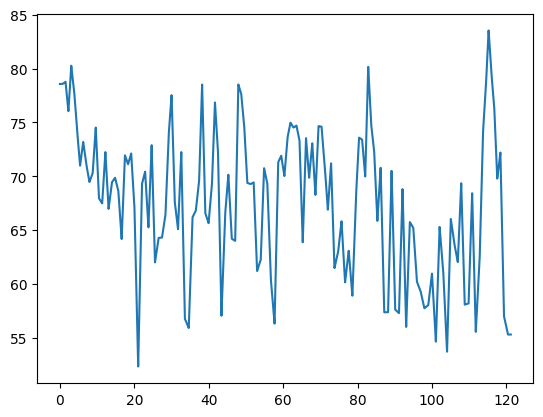

Średnie tętno: 67.87574454340016
Odchylenie std.: 6.7579218923089


In [ ]:
sig = signal('spocz_czyste')
hr(sig)

#### HRV ####

In [ ]:
def hrv(name):
  sig = signal(name)
  peaks = find_R_peaks(sig)
  rr_x = 0.5 * (peaks[:-1] + peaks[1:]) / Fs
  # Skalowanie do milisekund
  rr = np.diff(peaks) / Fs * 1000

  interp = np.interp(timespan(sig), rr_x, rr)


  # Plotowanie wyników
  fig, axes = plt.subplots(1, 2, figsize=(10, 4))
  fig.suptitle(f"HRV {name}", fontsize=14)

  axes[0].set_title('Interwały R-R jako szereg czasowy')
  axes[0].set_xlabel('Czas (s)')
  axes[0].set_ylabel('interwały R-R  (ms)')
  axes[0].plot(timespan(sig), interp)


  axes[1].set_title('Estymacja widma')
  axes[1].set_xlabel('Częstość [Hz]')
  axes[1].set_ylabel('PSD [ms**2/Hz]')
  axes[1].set_xlim(0, 1)

  # celujemy w rozdzielczość w dziedzinie częstości ok. 0.01 Hz
  freq, _, Sxx = ss.spectrogram(interp, fs=Fs, nperseg=Fs*100, noverlap=Fs)
  axes[1].plot(freq, Sxx)

  # Analiza przedziałów częstości
  axes[1].axvspan(0.0033, 0.04, fc='green', alpha=0.2)
  axes[1].axvspan(0.04, 0.15, fc='orange', alpha=0.2)
  axes[1].axvspan(0.15, 0.4, fc='red', alpha=0.2)

  plt.tight_layout()
  plt.show()

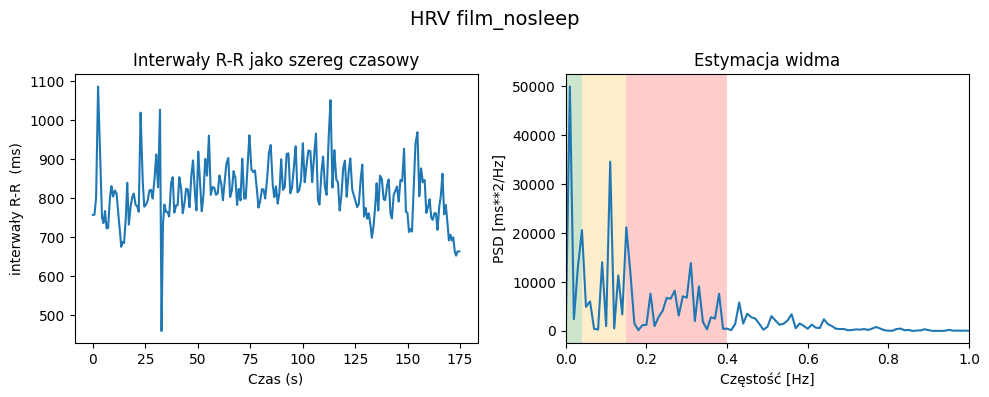

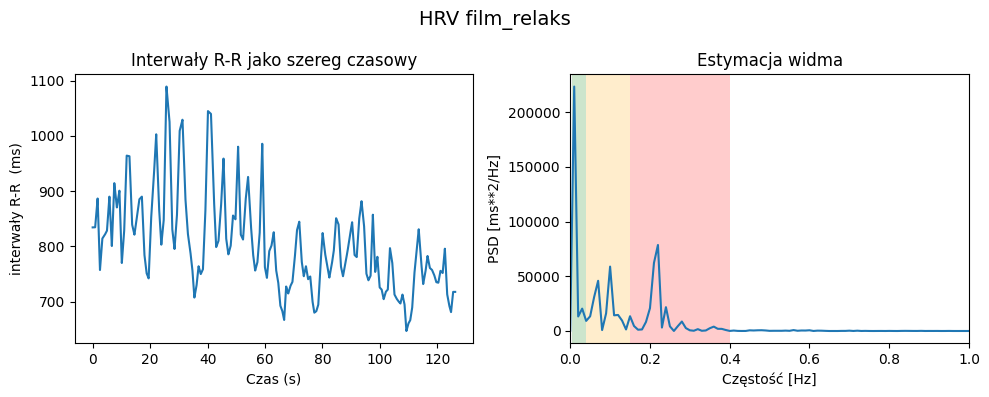

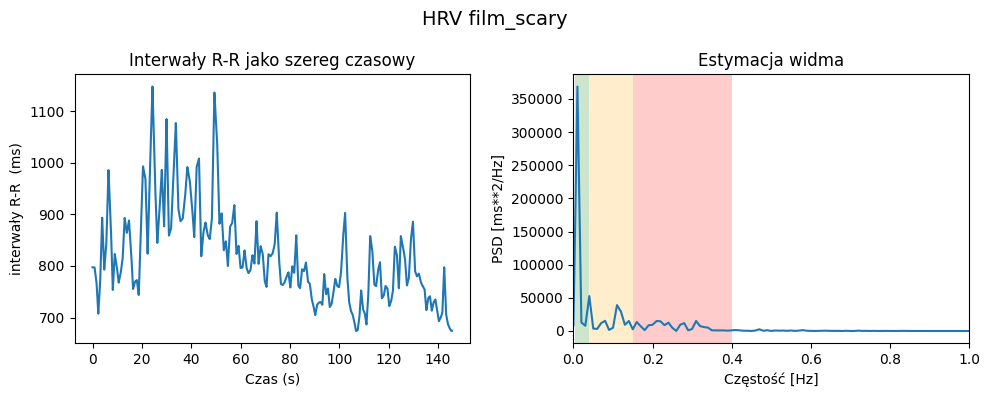

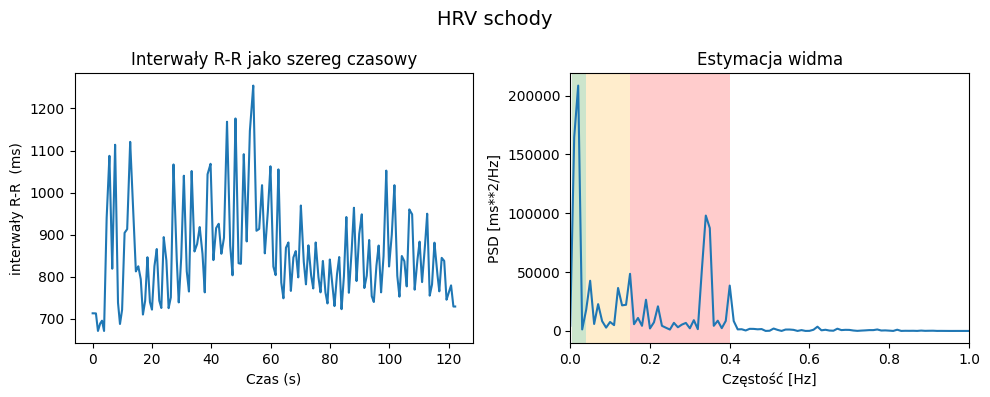

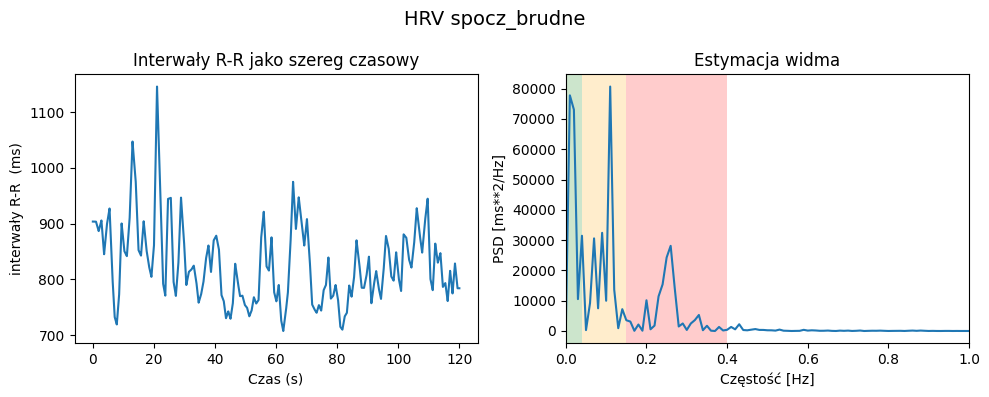

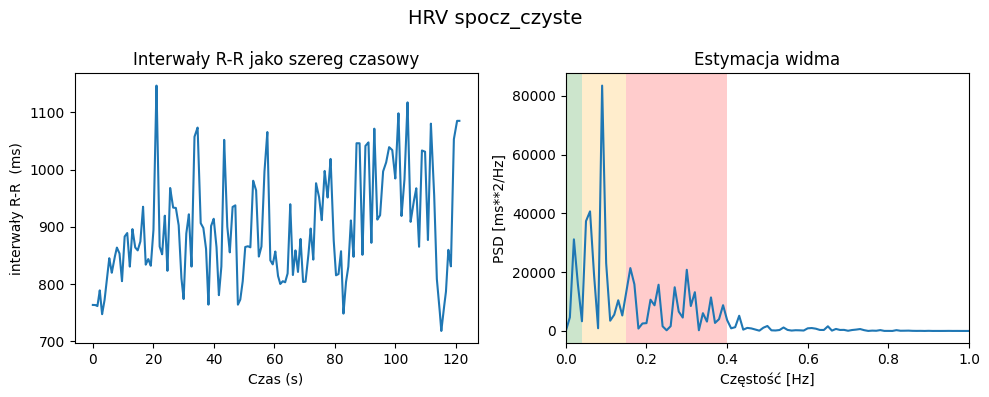

In [ ]:
for name in recordings:
  hrv(name)